In [2]:
import tensorflow as tf
import numpy as np

import scipy

import torch
import torchvision
from torch.legacy import nn
from scipy import ndimage, misc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

In [3]:
trainset = torchvision.datasets.ImageFolder("../data/faces_images/train/")
testset = torchvision.datasets.ImageFolder("../data/faces_images/test/")
testset.imgs, testset.class_to_idx == trainset.class_to_idx

([('../data/faces_images/test/A.J._Buckley/00000011.png', 0),
  ('../data/faces_images/test/A.J._Buckley/00000014.png', 0),
  ('../data/faces_images/test/A.J._Buckley/00000015.png', 0),
  ('../data/faces_images/test/A.J._Buckley/00000016.png', 0),
  ('../data/faces_images/test/A.J._Buckley/00000017.png', 0),
  ('../data/faces_images/test/A.J._Buckley/00000019.png', 0),
  ('../data/faces_images/test/A.R._Rahman/00000011.png', 1),
  ('../data/faces_images/test/A.R._Rahman/00000012.png', 1),
  ('../data/faces_images/test/A.R._Rahman/00000015.png', 1),
  ('../data/faces_images/test/A.R._Rahman/00000016.png', 1),
  ('../data/faces_images/test/A.R._Rahman/00000017.png', 1),
  ('../data/faces_images/test/A_P_J_Abdul_Kalam/00000011.png', 2),
  ('../data/faces_images/test/A_P_J_Abdul_Kalam/00000012.png', 2),
  ('../data/faces_images/test/A_P_J_Abdul_Kalam/00000013.png', 2),
  ('../data/faces_images/test/A_P_J_Abdul_Kalam/00000014.png', 2),
  ('../data/faces_images/test/A_P_J_Abdul_Kalam/0000001

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

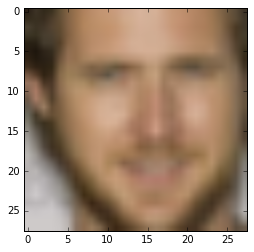

In [5]:
size = len(trainset)

train_x = np.array([misc.imresize(img,(28,28)) for img,label in trainset][:-(size%10)])
#train_x = np.array([misc.imresize(mpimg.imread(img),(28,28)) for img,label in trainset.imgs][:-(size%10)])
train_y = np.array([label for img,label in trainset.imgs][:-(size%10)])
train_y = np.identity(len(trainset.classes))[train_y]
test_x = np.array([misc.imresize(img,(28,28)) for img,label in testset])
#test_x = np.array([misc.imresize(mpimg.imread(img),(28,28)) for img,label in testset.imgs])
test_y = np.array([label for img,label in testset.imgs])
test_y = np.identity(len(testset.classes))[test_y]
for i in xrange(3):
    plt.imshow(train_x[i],)

In [6]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((150, 28, 28, 3), (150, 10), (58, 28, 28, 3), (58, 10))

## Prameters

In [7]:
batch_size = 32
epochs = 1000

n_input = 28*28 # (img shape: 28*28)
n_classes = len(trainset.classes) # total classes

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

def next_batch(num, data, labels):
    idx = np.arange(0 , len(trainset)/10*10)
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [8]:
with tf.Session() as sess:
    # Graph Input
    x = tf.placeholder(tf.float32, [None, 28,28,3], name="input_features")
    y = tf.placeholder(tf.float32, [None, n_classes], name="labels")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    # layer 1
    W_conv1 = weight_variable([5,5,3,32])
    b_conv1 = bias_variable([32])
    
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name="h_conv1")
    h_pool1 = max_pool_2x2(h_conv1)
    
    # layer 2
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name="h_conv2")
    h_pool2 = max_pool_2x2(h_conv2)
    
    # fully connected layer 1
    W_fc1 = weight_variable([7*7*64,1024])
    b_fc1 = bias_variable([1024])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name="flattened_pool_layer")
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1) + b_fc1, name="h_fc1")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")
    
    # fully connected layer 2
    W_fc2 = weight_variable([1024,n_classes])
    b_fc2 = bias_variable([n_classes])
    y_conv = tf.matmul(h_fc1_drop ,W_fc2) + b_fc2
    
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv), name="cross_entropy")
    train_step = tf.train.AdamOptimizer(1e-4,name="optimizer").minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1), name="correct_prediction")
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32), name="accuracy")
    
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        batch = next_batch(batch_size, train_x, train_y)
        if i%100==0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
            #train_accuracy = accuracy.eval(feed_dict={x: train_x, y: train_y, keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob:0.5})
        #train_step.run(feed_dict={x: train_x, y: train_y, keep_prob:0.5})
    test_accuracy = accuracy.eval(feed_dict={x: test_x, y: test_y, keep_prob: 1.0})
    print 'test accuracy %g' % test_accuracy
    
    #writer = tf.summary.FileWriter("log", y_conv.graph);

step 0, training accuracy 0.0625
step 100, training accuracy 0.71875
step 200, training accuracy 1
step 300, training accuracy 1
step 400, training accuracy 1
step 500, training accuracy 1
step 600, training accuracy 1
step 700, training accuracy 1
step 800, training accuracy 1
step 900, training accuracy 1
test accuracy 0.672414


In [10]:
# writer = tf.summary.FileWriter("log", sess.graph)